MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

Source dataset: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/IMG/USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.zip

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

## Define helper functions

In [2]:
from geomed3dv4 import *

In [3]:
# select work area
def crop_area(raster):
    return raster.sel(x=slice(575500-500,576000),y=slice(3642500+500,3642000))

def plot_fractality(ax, data):
    from scipy.stats import linregress
    import numpy as np
    import matplotlib.ticker as ticker

    ax.loglog(data.r, data, base=2, label='Calculated')
    ax.set_xlabel('Wavelength, m', fontsize=18)

    ax.axes.get_yaxis().set_visible(False)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    res = linregress(np.log2(data.r), np.log2(data))
    ax.plot(data.r, 2**(res.intercept + res.slope*np.log2(data.r)), 'r', label=f'Fitted R²={res.rvalue**2:.2f}', ls='--')

    ax.legend(fontsize=18)

    fractality = 1000*np.round((3 - (res.slope/2)),1)
    return fractality

### Load DEM

In [4]:
!wget -c https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/IMG/USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.zip

--2021-06-18 16:42:21--  https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/IMG/USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.zip
Resolving prd-tnm.s3.amazonaws.com (prd-tnm.s3.amazonaws.com)... 52.218.232.26
Connecting to prd-tnm.s3.amazonaws.com (prd-tnm.s3.amazonaws.com)|52.218.232.26|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
!unzip -p \
    USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.zip \
    USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.img > \
    USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.img

In [6]:
# DEM image
dem = crop_area(xr.open_rasterio("USGS_NED_one_meter_x57y365_CA_E_SanDiegoCo_2016_IMG_2017.img")[0])

dem

<xarray.DataArray (y: 1000, x: 1000)>
[1000000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 3.643e+06 3.643e+06 3.643e+06 ... 3.642e+06 3.642e+06
  * x        (x) float64 5.75e+05 5.75e+05 5.75e+05 ... 5.76e+05 5.76e+05
Attributes:
    transform:     (1.0, 0.0, 569993.9997, 0.0, -1.0, 3650006.0)
    crs:           +init=epsg:26911
    res:           (1.0, 1.0)
    is_tiled:      1
    nodatavals:    (-3.4028234663852886e+38,)
    scales:        (1.0,)
    offsets:       (0.0,)
    descriptions:  ('Layer_1',)

### Calculate spatial spectrum components

In [7]:
# check spatial components, [m]
gammas = np.arange(2,128)

dem_power = xr.DataArray([raster_gamma_range(dem, g-1, g+1, backward=True).std() for g in gammas],
                          coords=[gammas],
                          dims=['r'])

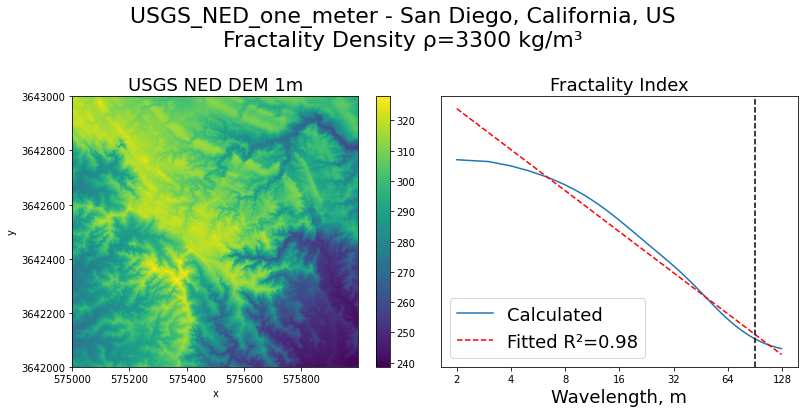

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dem.plot(ax=ax1)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title('USGS NED DEM 1m', fontsize=18)

dem_fractality = plot_fractality(ax2, dem_power)
ax2.set_title('Fractality Index', fontsize=18)
ax2.axvline(x=90, ymin=0, ymax=1, color = 'black', ls='--', alpha=1)

plt.suptitle(f"USGS_NED_one_meter - San Diego, California, US\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('USGS_NED_one_meter - San Diego, California, US.jpg', dpi=150)
plt.show()